# Set Up


In [139]:
#for future installs

# ! pip install opencv-python

# ! pip list

In [4]:
import numpy as np
from PIL import Image
import colorsys
import pandas as pd
# import pymeanshift as pms

#loading base file

filename = 'dx_succulent_bricks.jpg'
with Image.open(filename) as img:
    base = img.load()

In [5]:
type(base)

PixelAccess

In [141]:
# turinging the wihle file into a 3-d array.
## Currently a test with no future uses in this fiel. 
big_array = np.asarray(filename)
big_array

array('dx_succulent_bricks.jpg', dtype='<U23')

# Evaluating and splitting up the image

In [142]:
# type(img)
# img.show()


# sectioning out just the size of the img (not array)
dim = img.size

#the values stored in X and Y are specific to the loaded image (instance dependent)
type(dim)
x = dim[0]
y = dim[1]

# creating 'third' and 'sixth' variables for splitting up the image into 9 segments
## This code is used for all segmenting (instance independent)
thr = 0.33 
sxt = 0.67
scale = [0, thr, sxt, 1]

In [143]:
# Crop Matrix is INSTANCE DEPENDENT (using X and Y pulled from the dimensions of the image loaded)
crop_matrix = [(int(scale[i]*x), int(scale[j]*y)) for i in range(len(scale)) for j in range(len(scale))]
# print(crop_matrix)

# CPP is Instance Independent (InInd) -- each tuple identifies the upper-left and lower-right points to draw a rectangle over 1/9th of the image
cropping_point_pairs = [(0,5), (1,6), (2, 7), 
                        (4, 9), (5, 10), (6,11),
                        (8,13), (9,14), (10,15)]

# Crop coords are specific to the image loaded (InDe)
crop_coords = [(crop_matrix[p[0]][0], crop_matrix[p[0]][1], crop_matrix[p[1]][0], crop_matrix[p[1]][1]) for p in cropping_point_pairs]
# print(crop_coords)

# This is where the actual image is broken up into chunks

# lets try to do this part dynamically as each segment is required for processing
segments = [img.crop(i) for i in crop_coords]

# segments[5].show()


In [144]:
# naming an image for testing
play_seg = segments[5]
ps_array = np.asarray(play_seg) # turn image into an np array

# Gamma is a constant (can be ALL CAPS)
gamma = 2.2

# linearization calculation from Phil
linear_ps_array = (ps_array/255)**(1/gamma)

# linearization made very tiny numbers, bringing them back into visible range (rebit) and cast as a type PIL can read 
remult = np.round(linear_ps_array*255).astype(np.uint8) 

# remult is an rgb numpy array
'''
#original image
Image.fromarray(ps_array)

#linearized Image
lin_img = Image.fromarray(remult)
lin_img
'''

'\n#original image\nImage.fromarray(ps_array)\n\n#linearized Image\nlin_img = Image.fromarray(remult)\nlin_img\n'

In [ ]:
#short fork at this point to put remult in a pd array and get rgb mean/median/mode

It's so satisfying that I can hit "run cells above" and they all execute perfectly.

In [145]:
remult.shape
#each mini list is one pixel.

(1089, 867, 3)

In [146]:
# getting the center pixel values in (linearized) RGB values

center_row = int(round(remult.shape[0]/2))
center_col = int(round(remult.shape[1]/2))

rgb_center = tuple(remult[center_row, center_col, : ])

rgb_center

(151, 164, 56)

## HSL code

In [147]:
# Converting the whole thing to HSL (with the hue values properly corrected)
# takes 20s on laptop

def rgb_to_hsl(rgb):
    r, g, b = rgb/255
    h, l, s = colorsys.rgb_to_hls(r,g,b)
    return [h, s, l]

hsl_array = np.apply_along_axis(rgb_to_hsl, axis=-1, arr=remult)

hsl_array[:,:,0] = hsl_array[:,:,0] * 360 ## FFS, i was trying to convert all the pixels in the first column, not the hue layer.

In [148]:
# getting the same center pixel in HSL

center_v = int(round(hsl_array.shape[0]/2))
center_w = int(round(hsl_array.shape[1]/2))

hsl_center = list(hsl_array[center_v, center_w, : ])

hsl_center

[67.22222222222221, 0.49090909090909096, 0.43137254901960786]

In [149]:
hsl_array.shape

(1089, 867, 3)

In [150]:
# putting all the pixels in a blender then sorting them.
#reshaping to HSL columns in numpy
hsl_pixels = hsl_array.reshape((hsl_array.shape[0]*hsl_array.shape[1]), 3)

#converting to dataframe
hsl_pixel_df = pd.DataFrame(hsl_pixels)
hsl_pixel_df.columns = ["hue", "saturation", "brightness"]

#also reshaping to discrete pixels
hsl_tuples = [tuple(row) for row in hsl_pixels]

#adding tuples as a row in the dataframe
hsl_pixel_df['combined'] = hsl_tuples


In [158]:
hsl_pixel_df.describe()

,hue,saturation,brightness
count,944163.000000,944163.000000,944163.000000
mean,78.782376,0.486201,0.447437
std,46.175361,0.303906,0.214763
min,0.000000,0.000000,0.000000
25%,52.500000,0.262295,0.272549
50%,65.669291,0.372340,0.441176
75%,90.612245,0.671875,0.601961
max,358.235294,1.000000,1.000000


In [151]:
common_pix

combined
(0.0, 0.0, 0.0)                       4777
(120.0, 1.0, 0.041176470588235294)    1956
(0.0, 1.0, 0.041176470588235294)      1936
(0.0, 0.0, 0.08235294117647059)       1909
Name: count, dtype: int64

In [152]:
#creates a data Series with top 4 most common pixels
common_pix = hsl_pixel_df.value_counts('combined').sort_values(ascending=False).head(4)

## is 4 enough? do I want to make it deeper so maybe a larger per-- nope. not gonna bother
# hsl_pixel_df.value_counts('combined').sort_values(ascending=False).head(15)

#average hue/saturation, brightness
mean_hue = hsl_pixel_df['hue'].mean()
mean_sat = hsl_pixel_df['saturation'].mean()
mean_bright = hsl_pixel_df['brightness'].mean()
print(mean_hue, mean_sat, mean_bright)

78.78237599282464 0.4862009931787247 0.44743675760705404


Color Dictionary:

red < 15
orange < 35
yellow < 80
green < 140
turqoise < 215
blue < 255
purple < 285
magenta < 340
red > 340

In [153]:
# assigning colors to the hues
color_dict = {
    15: 'red',
    35: 'orange',
    80: 'yellow',
    140: 'green',
    215: 'turq',
    235: 'blue',
    285: 'purple',
    340: 'magenta',
    361: 'red'
}

def color_conversion(hue):
    for key in color_dict.keys():
        if hue <= key:
            return color_dict[key]

hsl_pixel_df['color'] = hsl_pixel_df['hue'].apply(color_conversion)



In [154]:
#max brightness
max_bright = hsl_pixel_df['brightness'].max()

# number of pixels at max brightness
num_brightest = hsl_pixel_df[hsl_pixel_df['brightness'] >= max_bright-0.015].shape[0]

min_bright = hsl_pixel_df['brightness'].min()
num_darkest = hsl_pixel_df[hsl_pixel_df['brightness'] <= min_bright+0.015].shape[0]

In [162]:
# 25th percentile VALUE = 
# 50th percentile VALUE =
# 75th percentile VALUE =
# Min and max are redundant with prev. 
bright_quartiles = hsl_pixel_df['brightness'].describe()
# still need to break that down into component values (inxex 4, 5, 6)

# under 15 perecent overall VALUE count =
qty_bright = hsl_pixel_df[hsl_pixel_df['brightness'] >= .85].shape[0]

# over 85 percent overall VALUE count = 
qty_dark = hsl_pixel_df[hsl_pixel_df['brightness'] <= .15].shape[0]

sat_quarts = hsl_pixel_df['saturation'].describe() 
# index 3, 4, 5, 6, 7


#number of Pixels that are saturated, and in a mid range of brightness.
df_vivid = hsl_pixel_df[(hsl_pixel_df['saturation'] >= .7) & (hsl_pixel_df['brightness'] >= .30) & (hsl_pixel_df['brightness'] <= .70)]
qty_vivid = hsl_pixel_df[(hsl_pixel_df['saturation'] >= .7) & (hsl_pixel_df['brightness'] >= .30) & (hsl_pixel_df['brightness'] <= .70)].shape[0]


,hue,saturation,brightness,combined,color
283,187.792208,0.785714,0.384314,"(187.79220779220782, 0.7857142857142856, 0.384...",turq
284,187.951807,1.000000,0.325490,"(187.95180722891564, 1.0, 0.3254901960784314)",turq
285,187.764706,1.000000,0.333333,"(187.76470588235293, 1.0, 0.3333333333333333)",turq
294,188.275862,1.000000,0.341176,"(188.27586206896555, 1.0, 0.3411764705882353)",turq
295,190.469799,0.780105,0.374510,"(190.46979865771812, 0.7801047120418847, 0.374...",turq
...,...,...,...,...,...
943074,67.438017,0.742331,0.319608,"(67.43801652892562, 0.7423312883435582, 0.3196...",yellow
943122,96.097561,0.745455,0.323529,"(96.09756097560975, 0.7454545454545455, 0.3235...",green
943167,104.464286,0.727273,0.301961,"(104.46428571428572, 0.7272727272727273, 0.301...",green
943201,68.648649,0.725490,0.300000,"(68.64864864864867, 0.7254901960784313, 0.3000...",yellow


In [156]:
df_hue_enough = hsl_pixel_df[(hsl_pixel_df['saturation'] >= .4) & (hsl_pixel_df['brightness'] >= .20) & (hsl_pixel_df['brightness'] <= .75)]

In [157]:
#turn color counts into dict, which can be indexed by name
full_color_sep = dict(hsl_pixel_df['color'].value_counts())

vivid_color_sep = dict(df_vivid['color'].value_counts())

visible_color_sep = dict(df_hue_enough['color'].value_counts())


print(full_color_sep)
print(visible_color_sep)
print(vivid_color_sep)

{'yellow': 581763, 'green': 211917, 'turq': 78183, 'orange': 42135, 'red': 17666, 'purple': 5379, 'magenta': 5089, 'blue': 2031}
{'yellow': 185981, 'green': 49536, 'turq': 15648, 'orange': 5313, 'red': 87, 'magenta': 23, 'purple': 7, 'blue': 4}
{'yellow': 6182, 'turq': 2197, 'green': 737, 'orange': 5}


# pymeanshift

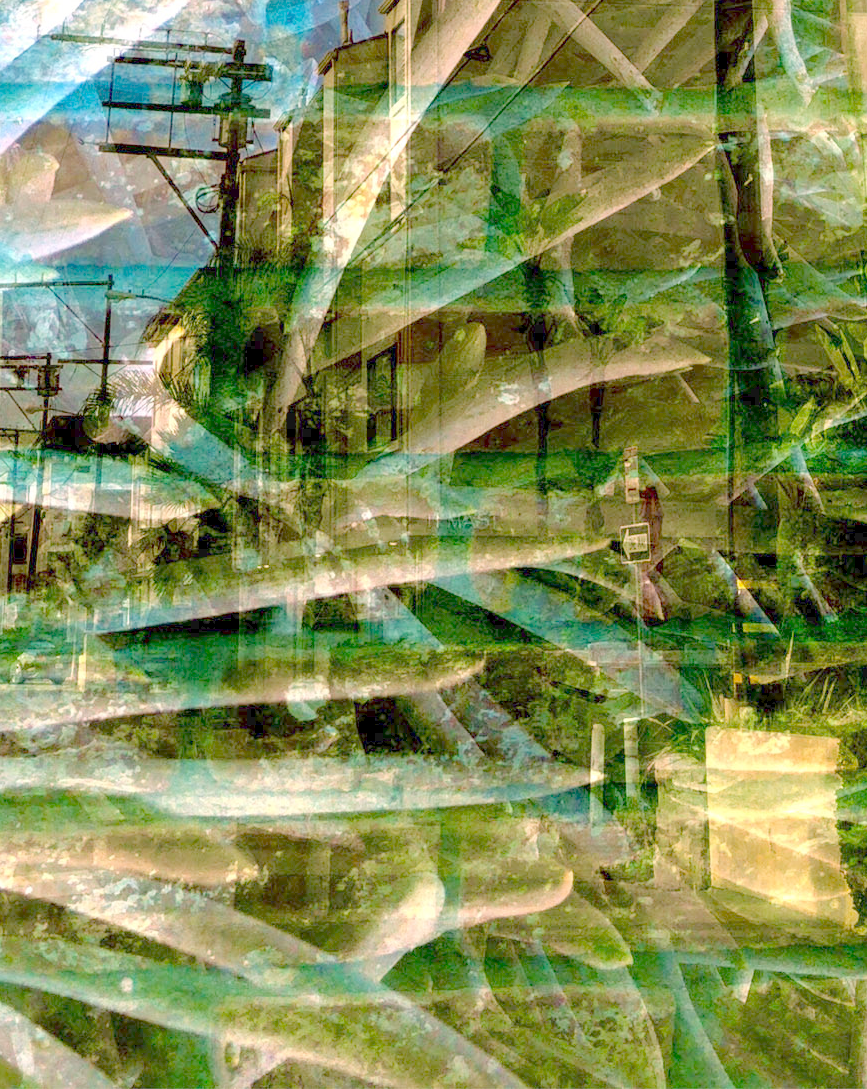

In [159]:
# visual comparison of the linearized original for running the segmenter against

lin_img = Image.fromarray(remult)
lin_img

799


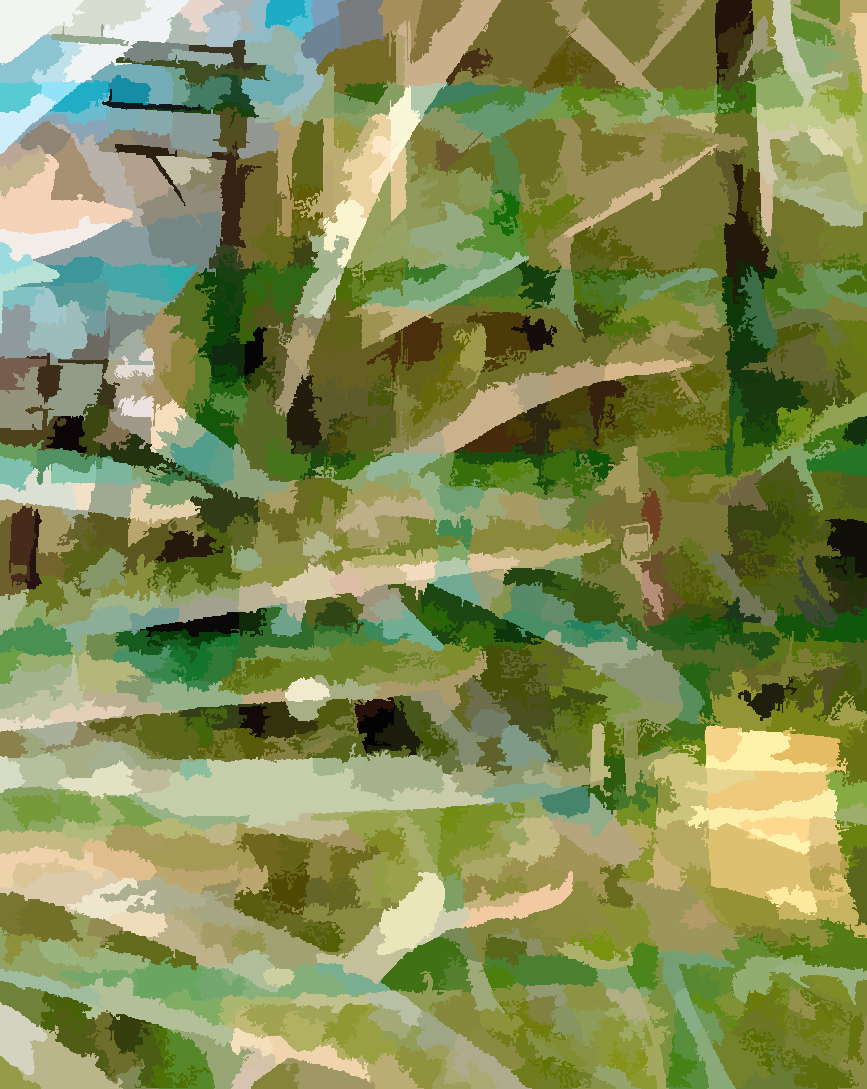

In [ ]:
# segmenter! and vis! running on a linearized image
(segmented_image, labels_image, number_regions) = pms.segment(lin_img, spatial_radius=7, 
                                                              range_radius=7, min_density=450)

# the segmented_image output is a rgb numpy array, so I can run it back through the HSL process.

# turning the np array back into something visual
seg_viz = Image.fromarray(segmented_image)

#I like this number_regions datapoint! let's keep it
# print(number_regions)

# looking at it
seg_viz

# HSL etc for segmented version

In [ ]:
# CHANGE LANGUAGE ABOUT CUTTING THE IMAGE INTO SMALLER PARTS TO PORTIONING
# so we don't get mixed up about this kind of segments
# this one takes 7.7 seconds, same as its brother

segment_hsl = np.apply_along_axis(rgb_to_hsl, axis=-1, arr=segmented_image)
segment_hsl[:,:,0] = segment_hsl[:,:,0] * 360

In [ ]:
#reshaping
seg_hsl_pixels = segment_hsl.reshape((segment_hsl.shape[0]*segment_hsl.shape[1]), 3)

#converting to dataframe
seg_df = pd.DataFrame(seg_hsl_pixels)
seg_df.columns = ["hue", "saturation", "brightness"]

#also reshaping to discrete pixels
seg_hsl_tuples = [tuple(row) for row in seg_hsl_pixels]

#adding tuples as a row in the dataframe
seg_df['combined'] = seg_hsl_tuples

In [ ]:
# top 6 colors are in! and most of the brigtnesses are in the middle!
common_seg_pix = seg_df.value_counts('combined').sort_values(ascending=False).head(6)

common_seg_pix

combined
(73.33333333333334, 0.2647058823529413, 0.7333333333333334)       10673
(56.470588235294116, 0.39999999999999997, 0.33333333333333337)     8574
(51.04477611940299, 0.28270042194092826, 0.4647058823529412)       6524
(44.036697247706414, 0.6158192090395481, 0.6529411764705882)       5957
(52.28571428571429, 0.43750000000000006, 0.3137254901960784)       5904
(26.440677966101678, 0.7283950617283955, 0.8411764705882353)       4534
Name: count, dtype: int64